# Introduction

We have gathered daily price data for the Iranian Gold Coin along with its corresponding option data. This data has been partially cleaned, with some features added and others dropped.

The objective of this notebook is to:

1. Prepare the price data and apply various machine learning, deep learning, and statistical models to forecast the price for future intervals.

2. Prepare the option data, utilize the forecasting from the first part, and employ the "Stochastic Calculus Models" module to identify profitable options.

### Notes
1. This notebook is a work in progress and will require further development in the future.

2. Real option pricing and analysis require additional data from other correlated assets and derivatives to ensure reliability.

3. Real option pricing and analysis necessitate more rigorous methods, potentially including tuned models and customized stochastic differential equations beyond standard approaches.

4. Interpretation of models and results is a critical aspect that remains incomplete in this work.

5. More historical and trading data is needed to enhance the robustness and reliability of our results.

# Data Preparation

In [1]:

import math
import talib
import random 
import optuna
import statistics
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import TimeSeriesSplit
from verstack import LGBMTuner


import seaborn as sns
from sklearn.svm import SVR
from numpy.random import seed
import matplotlib.pyplot as plt

import plotly.graph_objects as go

from sklearn.linear_model import ElasticNet,Lasso,Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression

from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from pandas import to_datetime

from prophet import Prophet

from statsmodels.tsa.arima.model import ARIMA
from statsforecast import StatsForecast
from statsforecast.models import (
    AutoARIMA,
    AutoCES,
    AutoETS,
    AutoRegressive,
    AutoTheta,
    SimpleExponentialSmoothing,
    SimpleExponentialSmoothingOptimized,
    SeasonalExponentialSmoothing,
    SeasonalExponentialSmoothingOptimized,
    Holt,
    HoltWinters,
    RandomWalkWithDrift,
    ADIDA,
    CrostonClassic,
    CrostonOptimized,
    CrostonSBA,
    IMAPA,
    TSB,
    MSTL,
    TBATS,
    AutoTBATS,
    Theta,
    OptimizedTheta,
    DynamicTheta,
    DynamicOptimizedTheta
)

import jdatetime
from datetime import datetime
from StochasticCalculusModeling import *
import pytorch_lightning as pl
from neuralforecast import NeuralForecast
from neuralforecast.models import RNN
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss

import warnings
warnings.filterwarnings('ignore')

In [2]:
GoldCoinPrice = pd.read_csv(r"C:\Users\Aleph.LAPTOP-5AKK0J1L\Desktop\Option Pricing\GoldCoinPrice.csv")
GoldCoinPrice.index = GoldCoinPrice['Date']
GoldCoinPrice = GoldCoinPrice.drop(['Change', 'ChangePercent'], axis=1)
GoldCoinPrice.head()

,Date,Open,Low,High,Close
Date,,,,,
1397/01/14,1397/01/14,17310000,17290000,17460000,17360000
1397/01/15,1397/01/15,17390000,17390000,17490000,17490000
1397/01/16,1397/01/16,17390000,17390000,17390000,17390000
1397/01/17,1397/01/17,17560000,17550000,17910000,17830000
1397/01/18,1397/01/18,18050000,18050000,19560000,19300000


In [3]:
GoldCoinOptions = pd.read_csv(r"C:\Users\Aleph.LAPTOP-5AKK0J1L\Desktop\Option Pricing\GoldCoinOptions.csv")
GoldCoinOptions.head()

,حجم,ارزش(ریال),بالاترین(ریال),پایین ترین(ریال),آخرین(ریال),اولین(ریال),موقعیتهای باز,درصد تغییر,تعداد مشتریان فعال,تعداد کارگزاران فعال,...,قیمت تسویه (ریال),درصد تغییر قیمت تسویه,تاریخ,تاریخ اعمال,#!ارزش معاملات مشتریان حقیقی(خرید)(ریال),#!ارزش معاملات مشتریان حقیقی(فروش)(ریال),ContractType,StrikePrice,Profitability,ContractDurationDays
0,0,0,0,0,0,0,39,0,21,7,...,4900000,0.00,1398/01/15,1398/02/16,0,0,C,46000000,1,32
1,11,54040000,5500000,4700000,4890000,5500000,40,0,22,10,...,4912727,18.12,1398/01/15,1398/02/16,54040000,54040000,C,44000000,1,32
2,14,34763400,2899400,2300000,2300400,2899400,352,-6,51,11,...,2483100,8.62,1398/01/15,1398/02/16,34763400,34763400,C,48000000,1,32
3,0,0,0,0,0,0,17,0,13,4,...,1145568,0.00,1398/01/15,1398/02/16,0,0,P,44000000,0,32
4,0,0,0,0,0,0,5,0,5,3,...,1573415,8.38,1398/01/15,1398/02/16,0,0,P,46000000,0,32


## Add Some Features
This section includes 8 funtions for Data Preparation:

1. Add_Lag: Add arbitrary numbers of lags of data columns.

2. Indicator: Add all possible technical analysis features to the data using "Talib" library.

3. add_diff: Add price differences of consecutive days.

4. Roll_Stats: Add simple statistics of columns like mean, standard deviation, maximum ad minimum.

5. Prepare_Data: Combine above functions and implement them on the data.

6. Combine: Consider the Label and according to it, then Prepare Data for each columns and at th end, concat or merge them together.

7. mutual_information: Due to the large number of created columns, it's better to select most related and important of them. Therefore, we calculate their mutual information score with the target column and by setting an arbitrary value like mic=3, we drop all columns which their MIC scores with the target is smaller than 3.

8. Final_Data_Preparation: The last function that all above functions will run in it. This function prepare the dataset and drop uncorrelated features and return the final clean data.

### Note
In the first version of this notebook, we assume the GoldCoinPrice data as a univariate time series with 'Close' feature.

In [5]:
def Add_Lag(data,col,lag_list):

    position = data.columns.tolist().index(col)
    
    for lag in lag_list:
    
        col_val = data[col].shift(lag)

        col_name = col+'_lag:'+'{length}'.format(length=lag)

        data.insert(loc=position, column=col_name, value=col_val)
        

    return data

def add_diff(data,col): #A simple type of features which calculate just the difference between sequential values in each columns

    position = data.columns.tolist().index(col)

    SimpleDiff = [0,0]
    LogDiff = [0,0]
    simpleReturn = [0,0]
    LogReturn = [0,0]

    for i in range(1,data.shape[0]-1):

        NaturalDifference = data[col][i] -  data[col][i-1]
        NaturalReturn = NaturalDifference / data[col][i-1]

        LogDiference = np.log(data[col][i]) - np.log(data[col][i-1])
        LogReturn_ = LogDiference / np.log(data[col][i-1])


        SimpleDiff.append(NaturalDifference)
        LogDiff.append(LogDiference)
        simpleReturn.append(NaturalReturn)
        LogReturn.append(LogReturn_)

    
    data.insert(loc=position, column=col+'_SimpleDifference', value=SimpleDiff)
    data.insert(loc=position, column=col+'_LogDifference', value=LogDiff)
    data.insert(loc=position, column=col+'_simpleReturn', value=simpleReturn)
    data.insert(loc=position, column=col+'_ LogReturn', value=LogReturn)

    return data

def Roll_Stats(data,col,Roll_Window): #Calculating simple statistics of the data
    
    lag = 1

    position = data.columns.tolist().index(col)
    
    for window in Roll_Window:
        
        Window = window
        col_val = data[col].shift(lag)
        window = col_val.rolling(window=window)
        means = window.mean()
        std = window.var()
        Max  = window.max()
        Min = window.min()
    
        col_name_mean = col+'_mean'+'_lag:'+'{length}'.format(length=lag)+\
        '_win:'+'{length}'.format(length=Window)
        col_name_std = col+'_std'+'_lag:'+'{length}'.format(length=lag)+\
        '_win:'+'{length}'.format(length=Window)
        col_name_max = col+'_max'+'_lag:'+'{length}'.format(length=lag)+\
        '_win:'+'{length}'.format(length=Window)
        col_name_min = col+'_min'+'_lag:'+'{length}'.format(length=lag)+\
        '_win:'+'{length}'.format(length=Window)


        data.insert(loc=position, column=col_name_mean, value=means)
        data.insert(loc=position, column=col_name_std, value=std)
        data.insert(loc=position, column=col_name_max, value=Max)
        data.insert(loc=position, column=col_name_min, value=Min)

    return data

def Add_Indicators(Data, data, col):
    target = data['Close']
    data = data.drop(['Close'],axis=1)
    # RSI period (default is 14)
    rsi = talib.RSI(data[col].values, timeperiod=14)

    macd, macd_signal, _ = talib.MACD(data[col].values)
    slowk, slowd = talib.STOCH(high=Data['High'].shift(1).values, low=Data['Low'].shift(1).values, close=data[col].values)
    upper_band, middle_band, lower_band = talib.BBANDS(data[col].values)
    sma = talib.SMA(data[col].values)

    # Add indicators to the DataFrame
    data['MACD'] = macd
    data['MACD_signal'] = macd_signal
    data['RSI'] = rsi
    data['Stochastic_SlowK'] = slowk
    data['Stochastic_SlowD'] = slowd
    data['BBands_upper'] = upper_band
    data['BBands_middle'] = middle_band
    data['BBands_lower'] = lower_band
    data['SMA'] = sma
    data['Close'] = target

    return data



def FeatureExtractor(data,lag_list,window_list):

    data = Add_Lag(data, 'Close',lag_list)
    data = add_diff(data, 'Close')
    data = Roll_Stats(data,'Close', window_list)
    data = Add_Indicators(GoldCoinPrice,data,'Close_lag:1')
    data = data.dropna()
    return data

In [6]:
data = pd.DataFrame(GoldCoinPrice['Close'])
Added_data = FeatureExtractor(data,[i for i in range(1,30)],[i for i in range(2,30)])
Added_data

,Close_lag:29,Close_lag:28,Close_lag:27,Close_lag:26,Close_lag:25,Close_lag:24,Close_lag:23,Close_lag:22,Close_lag:21,Close_lag:20,...,MACD,MACD_signal,RSI,Stochastic_SlowK,Stochastic_SlowD,BBands_upper,BBands_middle,BBands_lower,SMA,Close
Date,,,,,,,,,,,,,,,,,,,,,
1397/02/18,19550000.0,17700000.0,17910000.0,17850000.0,17850000.0,17810000.0,18560000.0,17970000.0,18400000.0,18290000.0,...,4.790696e+05,2.762043e+05,62.153563,39.765589,54.053632,2.098541e+07,19901000.0,1.881659e+07,1.854417e+07,20190000
1397/02/19,17700000.0,17910000.0,17850000.0,17850000.0,17810000.0,18560000.0,17970000.0,18400000.0,18290000.0,18290000.0,...,5.160334e+05,3.241701e+05,63.237778,38.934426,42.068773,2.108001e+07,20007000.0,1.893399e+07,1.857383e+07,21030000
1397/02/20,17910000.0,17850000.0,17850000.0,17810000.0,18560000.0,17970000.0,18400000.0,18290000.0,18290000.0,18350000.0,...,6.061214e+05,3.805604e+05,68.100595,69.314769,49.338261,2.144618e+07,20118000.0,1.878982e+07,1.862317e+07,21060000
1397/02/21,17850000.0,17850000.0,17810000.0,18560000.0,17970000.0,18400000.0,18290000.0,18290000.0,18350000.0,18200000.0,...,6.721890e+05,4.388861e+05,68.262065,85.708211,64.652469,2.178798e+07,20256000.0,1.872402e+07,1.873517e+07,20580000
1397/02/22,17850000.0,17810000.0,18560000.0,17970000.0,18400000.0,18290000.0,18290000.0,18350000.0,18200000.0,17700000.0,...,6.780005e+05,4.867090e+05,62.785909,88.543294,81.188758,2.142383e+07,20576000.0,1.972817e+07,1.882417e+07,19790000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1403/01/16,328510000.0,329360000.0,332880000.0,334540000.0,335540000.0,342100000.0,337490000.0,340090000.0,345050000.0,344580000.0,...,1.883806e+07,1.490013e+07,91.127945,70.462110,44.725775,4.480069e+08,404914000.0,3.618211e+08,3.660283e+08,458080000
1403/01/18,329360000.0,332880000.0,334540000.0,335540000.0,342100000.0,337490000.0,340090000.0,345050000.0,344580000.0,368070000.0,...,2.245962e+07,1.641203e+07,92.893358,98.056253,69.206074,4.745861e+08,418974000.0,3.633619e+08,3.702653e+08,448060000
1403/01/19,332880000.0,334540000.0,335540000.0,342100000.0,337490000.0,340090000.0,345050000.0,344580000.0,368070000.0,370850000.0,...,2.424176e+07,1.797798e+07,83.549676,91.765930,86.761431,4.801435e+08,431020000.0,3.818965e+08,3.742503e+08,419970000


## RFECV
After naively adding features, we need to drop bad ones. there are lots of methods for doing that, here we choose the rigorous and automatic method which named RFECV.

Selected Features: [  0   4  12  13  15  18  19  26  30  31  32 145 146 147 148 149 153]


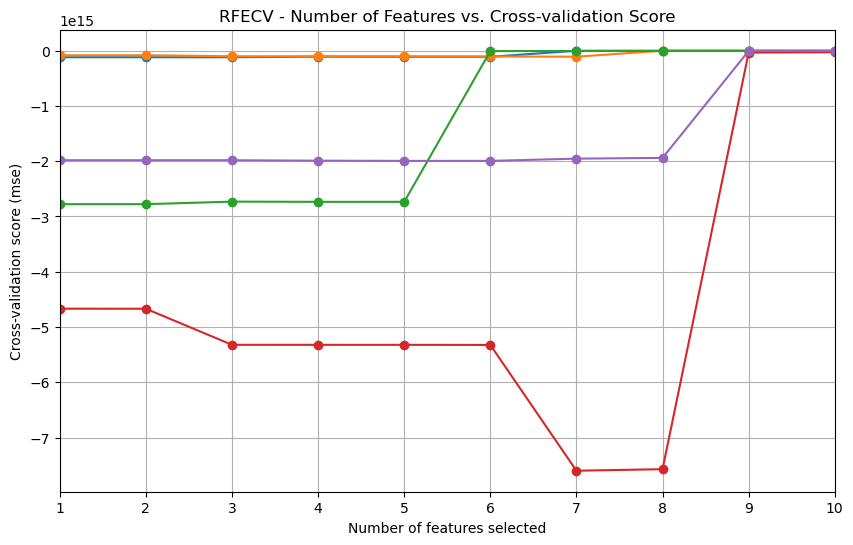

In [6]:
train_x, train_y = Added_data.values[:1100,:-1], Added_data.values[:1100,-1]
val_x, val_y = Added_data.values[1100:1500,:-1], Added_data.values[1100:1500,-1]
test_x, test_y = Added_data.values[1500:,:-1], Added_data.values[1500:,-1]

# Create a random forest regressor
#rf = RandomForestRegressor(n_jobs=-1)
EN = ElasticNet(alpha=0.1,l1_ratio=0.9)
tscv = TimeSeriesSplit(n_splits=5)
# Create the RFECV object
rfecv = RFECV(estimator=EN, step=1, cv=tscv, scoring='neg_mean_squared_error', min_features_to_select=1,n_jobs=-1)

# Fit the RFECV
rfecv.fit(train_x, train_y)

# Get the selected features
selected_features = np.where(rfecv.support_ == True)[0]

# Print the selected features
print("Selected Features:", selected_features)

# Plot number of features vs. cross-validation scores
plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (mse)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, marker='o', linestyle='-')
plt.xlim(1, 10)  # Limit x-axis to 10 features
plt.xticks(range(1, 11))
plt.grid(True)
plt.title('RFECV - Number of Features vs. Cross-validation Score')
plt.show()

In [15]:
selected_feature_names = Added_data.columns[[0, 4, 12, 13, 15, 18, 19, 26,28, 30, 31, 32, 145, 146, 147, 148, 149, 153,154]]

Added_data = Added_data[selected_feature_names]
Added_data

,Close_lag:29,Close_lag:25,Close_lag:17,Close_lag:16,Close_lag:14,Close_lag:11,Close_lag:10,Close_lag:3,Close_lag:1,Close_simpleReturn,Close_LogDifference,Close_SimpleDifference,MACD,MACD_signal,RSI,Stochastic_SlowK,Stochastic_SlowD,SMA,Close
Date,,,,,,,,,,,,,,,,,,,
1397/02/18,19550000.0,17850000.0,18200000.0,17700000.0,17470000.0,18000000.0,18450000.0,20370000.0,20020000.0,0.054795,0.053346,1040000,4.790696e+05,2.762043e+05,62.153563,39.765589,54.053632,1.854417e+07,20190000
1397/02/19,17700000.0,17810000.0,17700000.0,17600000.0,17670000.0,18450000.0,18550000.0,18980000.0,20190000.0,0.008492,0.008456,170000,5.160334e+05,3.241701e+05,63.237778,38.934426,42.068773,1.857383e+07,21030000
1397/02/20,17910000.0,18560000.0,17600000.0,17470000.0,17670000.0,18550000.0,19000000.0,20020000.0,21030000.0,0.041605,0.040763,840000,6.061214e+05,3.805604e+05,68.100595,69.314769,49.338261,1.862317e+07,21060000
1397/02/21,17850000.0,17970000.0,17470000.0,17670000.0,18000000.0,19000000.0,19080000.0,20190000.0,21060000.0,0.001427,0.001426,30000,6.721890e+05,4.388861e+05,68.262065,85.708211,64.652469,1.873517e+07,20580000
1397/02/22,17850000.0,18400000.0,17670000.0,17670000.0,18450000.0,19080000.0,19600000.0,21030000.0,20580000.0,-0.022792,-0.023056,-480000,6.780005e+05,4.867090e+05,62.785909,88.543294,81.188758,1.882417e+07,19790000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1403/01/16,328510000.0,335540000.0,372540000.0,362880000.0,366850000.0,376920000.0,380820000.0,387980000.0,438880000.0,0.039754,0.038984,16780000,1.883806e+07,1.490013e+07,91.127945,70.462110,44.725775,3.660283e+08,458080000
1403/01/18,329360000.0,342100000.0,362880000.0,366580000.0,367010000.0,380820000.0,388060000.0,422100000.0,458080000.0,0.043748,0.042818,19200000,2.245962e+07,1.641203e+07,92.893358,98.056253,69.206074,3.702653e+08,448060000
1403/01/19,332880000.0,337490000.0,366580000.0,366850000.0,371050000.0,388060000.0,387930000.0,438880000.0,448060000.0,-0.021874,-0.022117,-10020000,2.424176e+07,1.797798e+07,83.549676,91.765930,86.761431,3.742503e+08,419970000


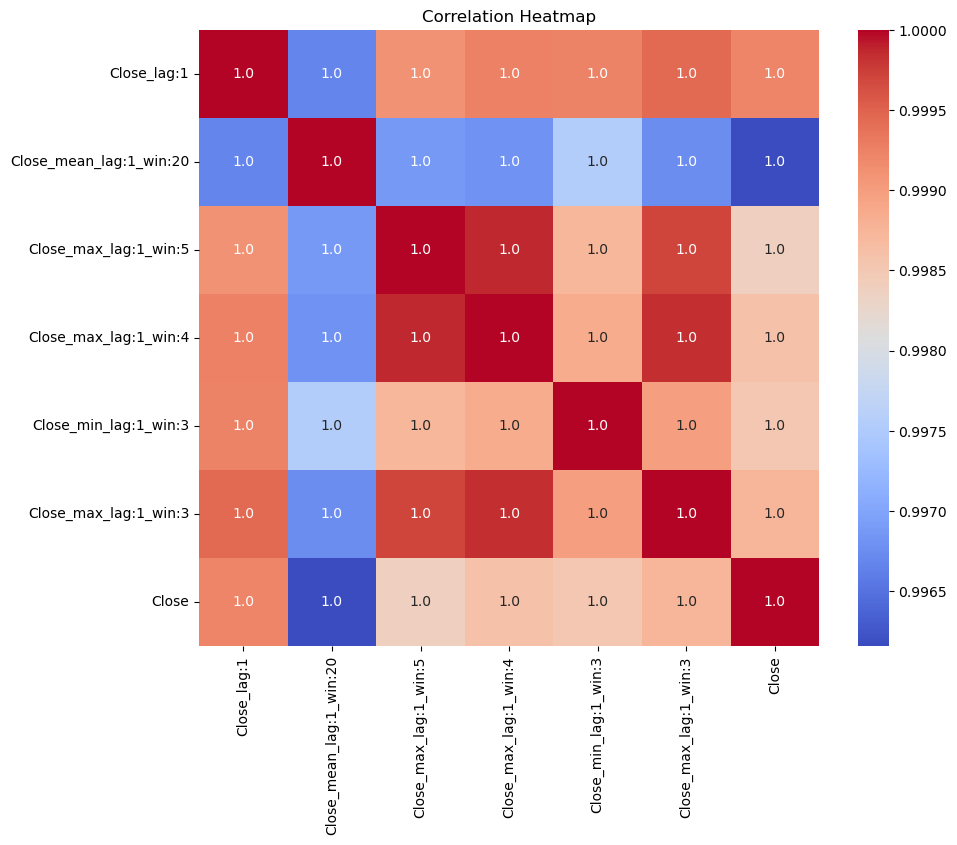

In [110]:
corr_matrix = Added_data.corr()
# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".1f")
plt.title('Correlation Heatmap')
plt.show()

In [35]:
# Calculate mutual information
mi_values = []
for column in Added_data.columns[:-1]:
    mi = mutual_info_regression(Added_data[[column]], Added_data['Close'])
    mi_values.append(mi[0])

# Calculate correlation with 'Close'
corr_values = Added_data.corr()['Close'].values

# Create the mutual information table
mi_df = pd.DataFrame({'Feature': Added_data.columns[:-1], 'Mutual_Information': mi_values, 'Correlation_with_Close': corr_values[:-1]})
mi_df = mi_df.sort_values(by='Mutual_Information', ascending=False).reset_index(drop=True)

mi_df

,Feature,Mutual_Information,Correlation_with_Close
0,Close_lag:1,3.296385,0.999226
1,Close_mean_lag:1_win:2,3.170984,0.999025
2,Close_max_lag:1_win:2,3.165788,0.998911
3,Close_min_lag:1_win:2,3.137546,0.998890
4,Close_max_lag:1_win:3,3.104040,0.998731
...,...,...,...
224,Stochastic_SlowK,0.084417,-0.045495
225,Close_SimpleDifference,0.072824,0.073251
226,Close_LogDifference,0.060943,0.012846
227,Close_simpleReturn,0.060773,0.012323


We can surely continue work on the data. for example we should make the data stationary 

# Forecasting Gold Coin Price

## Machine Learning Models

In [17]:
train_x, train_y = Added_data.values[:1200,:-1], Added_data.values[:1200,-1]
val_x, val_y = Added_data.values[1200:1700,:-1], Added_data.values[1200:1700,-1]
test_x, test_y = Added_data.values[1700:,:-1], Added_data.values[1700:,-1]

### 0. Base Model

To evaluate the performance of the models we will work on, it is better to have a base model, which its prediction is the lag 1 of the target e.g. $\hat{y}(t) = y(t-1) $.

In [18]:
def BaseModel(train_y, val_y):

    BasePrediction = [train_y[-1]]

    for i in range(len(val_y)-1):

        BasePrediction.append(val_y[i])
    
    return BasePrediction
     
BasePrediction = BaseModel(train_y, val_y)
# Calculate accuracy metrics
mae = mean_absolute_error(val_y, BasePrediction)
mse = mean_squared_error(val_y, BasePrediction)
rmse = np.sqrt(mse)
r2 = r2_score(val_y, BasePrediction)


print("Mean Absolute Error (MSE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2):", r2)

# Plot the predictions against the actual values
fig = go.Figure()
fig.add_trace(go.Scatter(x=Added_data.index[1200:1700], y=val_y, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=Added_data.index[1200:1700], y=BasePrediction, mode='lines', name='Predicted', line=dict(dash='dash')))
fig.update_layout(title='Base Model vs Actual', xaxis_title='Date', yaxis_title='Value', hovermode='x')
fig.show()

Mean Absolute Error (MSE): 2678994.0
Mean Squared Error (MSE): 27307386837040.0
Root Mean Squared Error (RMSE): 5225647.025683996
R-squared (R2): 0.9946049181592032


### 1. ElasticNet

In [19]:
# Scale the input data
scaler_x = StandardScaler()
train_x_scaled = scaler_x.fit_transform(train_x)
val_x_scaled = scaler_x.transform(val_x)

scaler_y = StandardScaler()
train_y_scaled = scaler_y.fit_transform(train_y.reshape(-1, 1)).ravel()

def objective(trial):
    alpha = trial.suggest_uniform('alpha', 0, 1)
    l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)
    max_iter = trial.suggest_int('max_iter', 1000, 10000)

    elastic_net = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=max_iter)
    elastic_net.fit(train_x_scaled, train_y_scaled)
    
    val_predictions_scaled = elastic_net.predict(val_x_scaled)
    val_predictions = scaler_y.inverse_transform(val_predictions_scaled.reshape(-1, 1)).ravel()
    
    mse = mean_squared_error(val_y, val_predictions)
    return mse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=400)

best_alpha = study.best_params['alpha']
best_l1_ratio = study.best_params['l1_ratio']
best_max_iter = study.best_params['max_iter']

# Train the model with the best hyperparameters
elastic_net = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio, max_iter=best_max_iter)
elastic_net.fit(train_x_scaled, train_y_scaled)

val_predictions_scaled = elastic_net.predict(val_x_scaled)
val_predictions = scaler_y.inverse_transform(val_predictions_scaled.reshape(-1, 1)).ravel()

# Calculate accuracy metrics
mae = mean_absolute_error(val_y, val_predictions)
mse = mean_squared_error(val_y, val_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(val_y, val_predictions)

print("Best alpha:", best_alpha)
print("Best l1_ratio:", best_l1_ratio)
print("Best max_iter:", best_max_iter)
print("Mean Absolute Error (MSE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2):", r2)

# Plot the predictions against the actual values
fig = go.Figure()
fig.add_trace(go.Scatter(x=Added_data.index[1200:1700], y=val_y, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=Added_data.index[1200:1700], y=val_predictions, mode='lines', name='Predicted', line=dict(dash='dash')))
fig.update_layout(title='ElasticNet vs Actual', xaxis_title='Date', yaxis_title='Value', hovermode='x')
fig.show()

[I 2024-04-12 18:15:36,340] A new study created in memory with name: no-name-be1423fc-79a5-449d-8d18-228ed0db883f
[I 2024-04-12 18:15:36,349] Trial 0 finished with value: 408944128335861.4 and parameters: {'alpha': 0.2692883592729387, 'l1_ratio': 0.31064946576574903, 'max_iter': 8511}. Best is trial 0 with value: 408944128335861.4.
[I 2024-04-12 18:15:36,353] Trial 1 finished with value: 526876680381074.2 and parameters: {'alpha': 0.1804478346529358, 'l1_ratio': 0.7274737003157451, 'max_iter': 2148}. Best is trial 0 with value: 408944128335861.4.
[I 2024-04-12 18:15:36,354] Trial 2 finished with value: 6774975500898765.0 and parameters: {'alpha': 0.9876548969146117, 'l1_ratio': 0.5470407438516292, 'max_iter': 2580}. Best is trial 0 with value: 408944128335861.4.
[I 2024-04-12 18:15:36,360] Trial 3 finished with value: 7618585277220100.0 and parameters: {'alpha': 0.754641076346481, 'l1_ratio': 0.7871184010794416, 'max_iter': 9196}. Best is trial 0 with value: 408944128335861.4.
[I 2024-

Best alpha: 0.000431217530228413
Best l1_ratio: 0.8992576232180597
Best max_iter: 5189
Mean Absolute Error (MSE): 2700133.9480515914
Mean Squared Error (MSE): 26729118037742.785
Root Mean Squared Error (RMSE): 5170021.086779317
R-squared (R2): 0.9947191659089716


## 2. Prophet

In [7]:
prophet_data = pd.DataFrame(columns = ['ds', 'y'])
prophet_data['ds'] = Added_data.index
prophet_data['y'] = Added_data['Close'].values
prophet_data

,ds,y
0,1397/02/18,20190000
1,1397/02/19,21030000
2,1397/02/20,21060000
3,1397/02/21,20580000
4,1397/02/22,19790000
...,...,...
1881,1403/01/16,458080000
1882,1403/01/18,448060000
1883,1403/01/19,419970000
1884,1403/01/20,415800000


In [8]:
# Assuming 'ds' is the column with the date
prophet_data['ds'] = prophet_data['ds'].apply(lambda x: jdatetime.datetime.strptime(x, '%Y/%m/%d').togregorian().strftime('%Y-%m-%d'))
prophet_data['ds'] = pd.to_datetime(prophet_data['ds'])

print(prophet_data)

             ds          y
0    2018-05-08   20190000
1    2018-05-09   21030000
2    2018-05-10   21060000
3    2018-05-11   20580000
4    2018-05-12   19790000
...         ...        ...
1881 2024-04-04  458080000
1882 2024-04-06  448060000
1883 2024-04-07  419970000
1884 2024-04-08  415800000
1885 2024-04-09  437060000

[1886 rows x 2 columns]


In [37]:
# Initialize Prophet model
model = Prophet()
prophet_data
# Fit the model
model.fit(prophet_data.iloc[:1200, :])

# Make future predictions
future = model.make_future_dataframe(periods=500)  # Forecasting for the next 30 days
forecast = model.predict(future)
forecast

18:47:16 - cmdstanpy - INFO - Chain [1] start processing
18:47:16 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-05-08,2.296017e+07,1.335670e+07,2.527120e+07,2.296017e+07,2.296017e+07,-3.245739e+06,-3.245739e+06,-3.245739e+06,172639.485803,172639.485803,172639.485803,-3.418378e+06,-3.418378e+06,-3.418378e+06,0.0,0.0,0.0,1.971443e+07
1,2018-05-09,2.307670e+07,1.348745e+07,2.552497e+07,2.307670e+07,2.307670e+07,-3.298608e+06,-3.298608e+06,-3.298608e+06,-10425.934068,-10425.934068,-10425.934068,-3.288182e+06,-3.288182e+06,-3.288182e+06,0.0,0.0,0.0,1.977810e+07
2,2018-05-10,2.319324e+07,1.411278e+07,2.581168e+07,2.319324e+07,2.319324e+07,-3.329330e+06,-3.329330e+06,-3.329330e+06,-171936.236318,-171936.236318,-171936.236318,-3.157394e+06,-3.157394e+06,-3.157394e+06,0.0,0.0,0.0,1.986391e+07
3,2018-05-11,2.330977e+07,1.437788e+07,2.614379e+07,2.330977e+07,2.330977e+07,-3.293618e+06,-3.293618e+06,-3.293618e+06,-264515.307449,-264515.307449,-264515.307449,-3.029103e+06,-3.029103e+06,-3.029103e+06,0.0,0.0,0.0,2.001615e+07
4,2018-05-12,2.342630e+07,1.427629e+07,2.612412e+07,2.342630e+07,2.342630e+07,-2.960925e+06,-2.960925e+06,-2.960925e+06,-54717.191981,-54717.191981,-54717.191981,-2.906208e+06,-2.906208e+06,-2.906208e+06,0.0,0.0,0.0,2.046537e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1695,2023-06-18,1.864623e+08,8.438693e+07,2.751963e+08,8.791012e+07,2.784457e+08,-2.231231e+06,-2.231231e+06,-2.231231e+06,168105.574311,168105.574311,168105.574311,-2.399337e+06,-2.399337e+06,-2.399337e+06,0.0,0.0,0.0,1.842311e+08
1696,2023-06-19,1.865729e+08,8.427705e+07,2.776838e+08,8.774407e+07,2.787927e+08,-2.090675e+06,-2.090675e+06,-2.090675e+06,160849.609701,160849.609701,160849.609701,-2.251524e+06,-2.251524e+06,-2.251524e+06,0.0,0.0,0.0,1.844822e+08
1697,2023-06-20,1.866834e+08,8.523792e+07,2.794172e+08,8.755216e+07,2.791355e+08,-1.925035e+06,-1.925035e+06,-1.925035e+06,172639.485803,172639.485803,172639.485803,-2.097675e+06,-2.097675e+06,-2.097675e+06,0.0,0.0,0.0,1.847583e+08
1698,2023-06-21,1.867939e+08,8.553308e+07,2.773481e+08,8.735233e+07,2.794783e+08,-1.949656e+06,-1.949656e+06,-1.949656e+06,-10425.934068,-10425.934068,-10425.934068,-1.939230e+06,-1.939230e+06,-1.939230e+06,0.0,0.0,0.0,1.848443e+08


In [43]:
# Plot the predictions against the actual values
fig = go.Figure()
fig.add_trace(go.Scatter(x=Added_data.index[1200:1700], y=val_y, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=Added_data.index[1200:1700], y=forecast['trend_upper'].values[1200:1700], mode='lines', name='trend_upper', line=dict(dash='dash')))
fig.add_trace(go.Scatter(x=Added_data.index[1200:1700], y=forecast['trend_lower'].values[1200:1700], mode='lines', name='trend_lower', line=dict(dash='dash')))
fig.add_trace(go.Scatter(x=Added_data.index[1200:1700], y=forecast['yhat_upper'].values[1200:1700], mode='lines', name='yhat_upper', line=dict(dash='dash')))
fig.add_trace(go.Scatter(x=Added_data.index[1200:1700], y=forecast['trend'].values[1200:1700], mode='lines', name='trend', line=dict(dash='dash')))

fig.update_layout(title='Prophet vs Actual', xaxis_title='Date', yaxis_title='Value', hovermode='x')
fig.show()

# Deep Learning Models

In [9]:
Close = pd.DataFrame(columns = ['unique_id','ds','y'])
Close['unique_id'] = ['Close' for i in range(prophet_data.shape[0])]
Close['ds'] = prophet_data['ds']
Close['y'] = prophet_data['y'] 
Close

,unique_id,ds,y
0,Close,2018-05-08,20190000
1,Close,2018-05-09,21030000
2,Close,2018-05-10,21060000
3,Close,2018-05-11,20580000
4,Close,2018-05-12,19790000
...,...,...,...
1881,Close,2024-04-04,458080000
1882,Close,2024-04-06,448060000
1883,Close,2024-04-07,419970000
1884,Close,2024-04-08,415800000


In [14]:
Y_train_df = Close.iloc[:1200,:]
Y_test_df = Close.iloc[1200:1230,:]
fcst = NeuralForecast(
    models=[RNN(h=30,
                input_size=-1,
                inference_input_size=24,
                loss=MQLoss(level=[80, 90]),
                scaler_type='robust',
                encoder_n_layers=2,
                encoder_hidden_size=128,
                context_size=10,
                decoder_hidden_size=128,
                decoder_layers=2,
                max_steps=300
                #futr_exog_list=['y_[lag12]'],
                #hist_exog_list=['y_[lag12]'],
                #stat_exog_list=['Close'],
                )
    ],
    freq='D'
)
fcst.fit(df=Y_train_df, val_size=30)
forecasts = fcst.predict(futr_df=Y_test_df)

Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['RNN-median'], c='blue', label='median')
plt.fill_between(x=plot_df['ds'][-12:], 
                 y1=plot_df['RNN-lo-90'][-12:].values, 
                 y2=plot_df['RNN-hi-90'][-12:].values,
                 alpha=0.4, label='level 90')
plt.legend()
plt.grid()
plt.plot()

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params
--------------------------------------------------
0 | loss            | MQLoss        | 5     
1 | padder          | ConstantPad1d | 0     
2 | scaler          | TemporalNorm  | 0     
3 | hist_encoder    | RNN           | 49.8 K
4 | context_adapter | Linear        | 38.7 K
5 | mlp_decoder     | MLP           | 2.1 K 
--------------------------------------------------
90.5 K    Trainable params
5         Non-trainable params
90.5 K    Total params
0.362     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=300` reached.


ValueError: There are missing combinations of ids and times in `futr_df`.
You can run the `make_future_dataframe()` method to get the expected combinations or the `get_missing_future(futr_df)` method to get the missing combinations.

In [19]:
fcst = NeuralForecast(
    models=[RNN(h=30,
                input_size=-1,
                inference_input_size=24,
                loss=MQLoss(level=[80, 90]),
                scaler_type='robust',
                encoder_n_layers=2,
                encoder_hidden_size=128,
                context_size=10,
                decoder_hidden_size=128,
                decoder_layers=2,
                max_steps=300
                #futr_exog_list=['y_[lag12]'],
                #hist_exog_list=['y_[lag12]'],
                #stat_exog_list=['Close'],
                )
    ],
    freq='D'
)
fcst.fit(df=Y_train_df, val_size=30)

# Create future dataframe with expected combinations of IDs and times
futr_df = fcst.make_future_dataframe(df=Y_train_df)

forecasts = fcst.predict(futr_df=futr_df)

fig = go.Figure()
fig.add_trace(go.Scatter(x=Added_data.index[1200:1230], y=Close['y'].values[1200:1230], mode='lines', name='Actual'))
for col in forecasts.columns[1:]:

    fig.add_trace(go.Scatter(x=Added_data.index[1200:1230], y=forecasts[f'{col}'].values, mode='lines', name=col, line=dict(dash='dash')))
#fig.add_trace(go.Scatter(x=Added_data.index[1200:1700], y=forecasts_df['DynamicOptimizedTheta-hi-90'].values, mode='lines', name='trend', line=dict(dash='dash')))

fig.update_layout(title='RNN Models Forecasting - 30 days', xaxis_title='Date', yaxis_title='Value', hovermode='x')
fig.show()


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params
--------------------------------------------------
0 | loss            | MQLoss        | 5     
1 | padder          | ConstantPad1d | 0     
2 | scaler          | TemporalNorm  | 0     
3 | hist_encoder    | RNN           | 49.8 K
4 | context_adapter | Linear        | 38.7 K
5 | mlp_decoder     | MLP           | 2.1 K 
--------------------------------------------------
90.5 K    Trainable params
5         Non-trainable params
90.5 K    Total params
0.362     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [17]:
forecasts

,ds,RNN-median,RNN-lo-90,RNN-lo-80,RNN-hi-80,RNN-hi-90
unique_id,,,,,,
Close,2022-02-08,118262576.0,112882640.0,114238640.0,122181472.0,123766992.0
Close,2022-02-09,118170768.0,112213432.0,112721128.0,123135728.0,124376512.0
Close,2022-02-10,118454320.0,111241744.0,112541584.0,123464280.0,126108968.0
Close,2022-02-11,118201728.0,110498416.0,112651552.0,124350256.0,127047712.0
Close,2022-02-12,118485192.0,110253856.0,111977600.0,125458784.0,127757104.0
Close,2022-02-13,118918320.0,109386800.0,112136736.0,125584600.0,128137040.0
Close,2022-02-14,118970576.0,109987904.0,111109920.0,126736016.0,129195440.0
Close,2022-02-15,119269192.0,109986752.0,110783488.0,127258608.0,130254488.0
Close,2022-02-16,119160336.0,109151280.0,111129632.0,127799472.0,129822984.0


# Statistical Models

Here we use statsforecast library for making forecast with multiple statistical models.\
"StatsForecast offers a collection of widely used univariate time series forecasting models, including automatic ARIMA, ETS, CES, and Theta modeling optimized for high performance using numba. It also includes a large battery of benchmarking models."

In [9]:
Close = pd.DataFrame(columns = ['unique_id','ds','y'])
Close['unique_id'] = ['Close' for i in range(prophet_data.shape[0])]
Close['ds'] = prophet_data['ds']
Close['y'] = prophet_data['y'] 
Close

,unique_id,ds,y
0,Close,2018-05-08,20190000
1,Close,2018-05-09,21030000
2,Close,2018-05-10,21060000
3,Close,2018-05-11,20580000
4,Close,2018-05-12,19790000
...,...,...,...
1881,Close,2024-04-04,458080000
1882,Close,2024-04-06,448060000
1883,Close,2024-04-07,419970000
1884,Close,2024-04-08,415800000


In [62]:
# Create a list of models and instantiation parameters
models = [
    AutoARIMA(season_length=24), AutoCES(), AutoETS(),AutoTheta(),
     SimpleExponentialSmoothing(alpha=0.5), SimpleExponentialSmoothingOptimized(),
    SeasonalExponentialSmoothing(alpha=0.5,season_length=24),SeasonalExponentialSmoothingOptimized(season_length=24),
    Holt(),HoltWinters(),RandomWalkWithDrift(),ADIDA(),CrostonClassic(),
    CrostonOptimized(),CrostonSBA(),IMAPA(),TSB(alpha_d=0.5,alpha_p = 0.5),MSTL(season_length=24),TBATS(season_length=24),AutoTBATS(season_length=24),
    Theta(),OptimizedTheta(), DynamicTheta(), DynamicOptimizedTheta()
]
#, AutoRegressive(lags=[1,5,10,20,30])

sf = StatsForecast(
    df=Close.iloc[:1200,:], 
    models=models,
    freq='D', #freq='D' means daily frequency
    n_jobs=-1,
    fallback_model = SeasonalNaive(season_length=7)
)

""" 
h (int): represents the forecast h steps into the future. In this case, 12 months ahead.

level (list of floats): this optional parameter is used for probabilistic forecasting.
 Set the level (or confidence percentile) of your prediction interval.
   For example, level=[90] means that the model expects the real value to be inside that interval 90% of the times.
"""

forecasts_df = sf.forecast(h=30, level=[90])

forecasts_df

,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90,CES,CES-lo-90,CES-hi-90,AutoETS,AutoETS-lo-90,AutoETS-hi-90,...,Theta-hi-90,OptimizedTheta,OptimizedTheta-lo-90,OptimizedTheta-hi-90,DynamicTheta,DynamicTheta-lo-90,DynamicTheta-hi-90,DynamicOptimizedTheta,DynamicOptimizedTheta-lo-90,DynamicOptimizedTheta-hi-90
unique_id,,,,,,,,,,,,,,,,,,,,,
Close,2022-02-08,115588672.0,112648608.0,118528736.0,116411424.0,113365024.0,119459536.0,115826352.0,111511216.0,120141480.0,...,119279824.0,115916920.0,113225240.0,119311984.0,115884768.0,113191352.0,119282032.0,115870176.0,113177336.0,119266712.0
Close,2022-02-09,115802448.0,111558280.0,120046616.0,116462936.0,113417760.0,119511448.0,115839616.0,109725720.0,121953520.0,...,120182880.0,115997728.0,111928936.0,120246848.0,115933696.0,111862352.0,120185632.0,115904672.0,111834208.0,120155704.0
Close,2022-02-10,116099392.0,110938672.0,121260104.0,116515296.0,113466888.0,119565944.0,115852888.0,108347936.0,123357832.0,...,121011752.0,116078536.0,110179608.0,121107488.0,115982584.0,110080048.0,121014992.0,115939136.0,110037880.0,120970480.0
Close,2022-02-11,116126600.0,110347600.0,121905592.0,116567016.0,113518704.0,119618424.0,115866152.0,107179680.0,124552624.0,...,121167512.0,116159344.0,110190744.0,121295000.0,116031424.0,110059440.0,121170824.0,115973568.0,110002872.0,121111888.0
Close,2022-02-12,116090984.0,109762576.0,122419392.0,116619288.0,113568616.0,119672536.0,115879424.0,106144312.0,125614528.0,...,122292624.0,116240152.0,110096712.0,122451840.0,116080224.0,109933560.0,122296632.0,116007984.0,109862656.0,122223040.0
Close,2022-02-13,116055520.0,109211224.0,122899816.0,116671160.0,113620016.0,119725392.0,115892688.0,105202600.0,126582776.0,...,123115960.0,116320960.0,108624256.0,123306904.0,116128976.0,108428496.0,123120480.0,116042368.0,108343552.0,123032344.0
Close,2022-02-14,116052632.0,108714672.0,123390584.0,116723392.0,113670288.0,119779296.0,115905952.0,104331304.0,127480608.0,...,123620736.0,116401768.0,107769216.0,123843360.0,116177688.0,107541200.0,123625544.0,116076720.0,107442128.0,123522904.0
Close,2022-02-15,116058008.0,108256640.0,123859384.0,116775376.0,113721440.0,119832400.0,115919224.0,103515296.0,128323152.0,...,124409240.0,116482576.0,107926880.0,124663480.0,116226352.0,107667232.0,124414520.0,116111040.0,107553760.0,124297384.0
Close,2022-02-16,116062280.0,107825016.0,124299536.0,116827600.0,113771968.0,119886192.0,115932488.0,102744112.0,129120864.0,...,124835672.0,116563384.0,107392544.0,125121688.0,116274984.0,107101056.0,124841224.0,116145328.0,106973440.0,124709608.0


In [64]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=Added_data.index[1200:1230], y=Close['y'].values[1200:1230], mode='lines', name='Actual'))
for col in forecasts_df.columns[1:]:

    fig.add_trace(go.Scatter(x=Added_data.index[1200:1230], y=forecasts_df[f'{col}'].values, mode='lines', name=col, line=dict(dash='dash')))
#fig.add_trace(go.Scatter(x=Added_data.index[1200:1700], y=forecasts_df['DynamicOptimizedTheta-hi-90'].values, mode='lines', name='trend', line=dict(dash='dash')))

fig.update_layout(title='Statistical Models Forecasting - 30 days', xaxis_title='Date', yaxis_title='Value', hovermode='x')
fig.show()

## Best Statistical Models
In this part we use different statistical models for forecasting the close price for periods of 30 days one after another.\
Then, we choose the best of them based on their mean MAE.

In [80]:
StatsModelsResult = {}

for model in forecasts_df.columns[1:]:
    StatsModelsResult[model] = []
    
for i in range(0,540,30):

    sf = StatsForecast(
        df=Close.iloc[:1200+i,:], 
        models=models,
        freq='D', #freq='D' means daily frequency
        n_jobs=-1,
        fallback_model = SeasonalNaive(season_length=7)
    )

    forecasts_df = sf.forecast(h=30, level=[90])
    for model in forecasts_df.columns[1:]:
        mae = mean_absolute_error(Close['y'].values[1200+i:1230+i], forecasts_df[model].values)
        StatsModelsResult[model].append(mae)

StatsModelMeanError = {}

for model in forecasts_df.columns[1:]:
    StatsModelMeanError[model] = 0
    
for model in forecasts_df.columns[1:]:

    StatsModelMeanError[model] = np.mean(StatsModelsResult[model])

#sort the models in dictionary based on their Error (Ascending)
    
sorted_StatsModelMeanError = dict(sorted(StatsModelMeanError.items(), key=lambda x: x[1]))
sorted_StatsModelMeanError

{'AutoETS': 11710572.562962964,
 'AutoTheta': 11892480.385185188,
 'OptimizedTheta': 11892480.385185188,
 'Theta': 11929766.325925924,
 'DynamicTheta': 11931372.103703706,
 'RWD': 11976473.85185185,
 'Holt': 11979207.2,
 'AutoTBATS': 11988058.474074075,
 'MSTL': 12026428.237037038,
 'SES': 12067153.718518518,
 'SESOpt': 12067153.718518518,
 'SeasonalES': 12067153.718518518,
 'SeasESOpt': 12067153.718518518,
 'HoltWinters': 12067153.718518518,
 'ADIDA': 12067153.718518518,
 'CrostonClassic': 12067153.718518518,
 'CrostonOptimized': 12067153.718518518,
 'CrostonSBA': 12067153.718518518,
 'IMAPA': 12067153.718518518,
 'TSB': 12067153.718518518,
 'DynamicOptimizedTheta': 12167282.34074074,
 'CES': 12454234.266666666,
 'TBATS': 12670562.474074075,
 'CES-lo-90': 13018845.125925926,
 'AutoARIMA': 13156958.992592596,
 'CES-hi-90': 13173275.925925925,
 'DynamicTheta-hi-90': 16373587.111111112,
 'Theta-hi-90': 16388006.948148148,
 'DynamicOptimizedTheta-hi-90': 16529757.525925927,
 'AutoTheta-hi

### Note
By tuning each of the above models, we can surely get better forecasting.

### 2. Support Vector Regression (SVR)

In [89]:
def objective(trial):
    C = trial.suggest_loguniform('C', 1e-5, 1e5)
    epsilon = trial.suggest_loguniform('epsilon', 1e-5, 1)
    gamma = trial.suggest_categorical('gamma', ['auto', 'scale'])

    svr = SVR(C=C, epsilon=epsilon, gamma=gamma)
    svr.fit(train_x_scaled, train_y_scaled)
    
    val_predictions_scaled = svr.predict(val_x_scaled)
    val_predictions = scaler_y.inverse_transform(val_predictions_scaled.reshape(-1, 1)).ravel()
    
    mse = mean_squared_error(val_y, val_predictions)
    return mse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

best_C = study.best_params['C']
best_epsilon = study.best_params['epsilon']
best_gamma = study.best_params['gamma']

# Train the model with the best hyperparameters
svr = SVR(C=best_C, epsilon=best_epsilon, gamma=best_gamma)
svr.fit(train_x_scaled, train_y_scaled)

val_predictions_scaled = svr.predict(val_x_scaled)
val_predictions = scaler_y.inverse_transform(val_predictions_scaled.reshape(-1, 1)).ravel()

# Calculate accuracy metrics
mae = mean_absolute_error(val_y, val_predictions)
mse = mean_squared_error(val_y, val_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(val_y, val_predictions)

print("Best C:", best_C)
print("Best epsilon:", best_epsilon)
print("Best gamma:", best_gamma)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2):", r2)

# Plot the predictions against the actual values
fig = go.Figure()
fig.add_trace(go.Scatter(x=Added_data.index[1100:1500], y=val_y, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=Added_data.index[1100:1500], y=val_predictions, mode='lines', name='Predicted', line=dict(dash='dash')))
fig.update_layout(title='SVR vs Actual', xaxis_title='Date', yaxis_title='Value', hovermode='x')
fig.show()

[I 2024-04-12 10:39:52,480] A new study created in memory with name: no-name-1f1c24d8-72c1-4039-8f18-f4ceecc98d9e
[I 2024-04-12 10:39:56,554] Trial 0 finished with value: 794015230904980.1 and parameters: {'C': 212.31668504952538, 'epsilon': 5.112105429899871e-05, 'gamma': 'auto'}. Best is trial 0 with value: 794015230904980.1.
[I 2024-04-12 10:39:56,611] Trial 1 finished with value: 6772735390265418.0 and parameters: {'C': 1.9234145861258973e-05, 'epsilon': 0.009022353743877796, 'gamma': 'scale'}. Best is trial 0 with value: 794015230904980.1.
[I 2024-04-12 10:40:09,942] Trial 2 finished with value: 1918384157550555.2 and parameters: {'C': 23803.806194904213, 'epsilon': 0.01641240362302434, 'gamma': 'auto'}. Best is trial 0 with value: 794015230904980.1.
[I 2024-04-12 10:40:09,991] Trial 3 finished with value: 6486032223550175.0 and parameters: {'C': 0.00017486755003019342, 'epsilon': 1.0220518700123216e-05, 'gamma': 'auto'}. Best is trial 0 with value: 794015230904980.1.
[I 2024-04-1

Best C: 3.9883793396266762
Best epsilon: 0.00032778243291043394
Best gamma: scale
Mean Absolute Error (MAE): 10879510.34448835
Mean Squared Error (MSE): 299847617348047.75
Root Mean Squared Error (RMSE): 17316108.60869288
R-squared (R2): 0.01574411657492203


### 3. LightGBMRegressor

In [86]:
# Define the time series cross-validation strategy
tscv = TimeSeriesSplit(n_splits=5)

def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'mae',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 100, 2000),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

    mse_scores = []
    for train_index, val_index in tscv.split(train_x):
        X_train, X_val = train_x[train_index], train_x[val_index]
        y_train, y_val = train_y[train_index], train_y[val_index]

        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

        gbm = lgb.train(params,
                        lgb_train,
                        valid_sets=[lgb_train, lgb_eval],
                        verbose_eval=False,
                        early_stopping_rounds=100)

        val_predictions = gbm.predict(X_val, num_iteration=gbm.best_iteration)

        mse_scores.append(mean_squared_error(y_val, val_predictions))

    return np.mean(mse_scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, n_jobs=1)

best_params = study.best_params

# Train the model with the best hyperparameters on the full training set
lgb_train = lgb.Dataset(train_x, train_y)
best_gbm = lgb.train(best_params,
                      lgb_train,
                      verbose_eval=False)

val_predictions = best_gbm.predict(val_x)

# Calculate accuracy metrics
mae = mean_absolute_error(val_y, val_predictions)
mse = mean_squared_error(val_y, val_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(val_y, val_predictions)

print("Best parameters:", best_params)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2):", r2)

# Plot the predictions against the actual values
fig = go.Figure()
fig.add_trace(go.Scatter(x=Added_data.index[1100:1700], y=val_y, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=Added_data.index[1100:1700], y=val_predictions, mode='lines', name='Predicted', line=dict(dash='dash')))
fig.update_layout(title='LGBM vs Actual', xaxis_title='Date', yaxis_title='Value', hovermode='x')
fig.show()

[I 2024-04-12 16:40:53,111] A new study created in memory with name: no-name-5a76d3bf-3359-4a95-aa39-c0148d0a250b
[I 2024-04-12 16:40:53,837] Trial 0 finished with value: 562588681944250.7 and parameters: {'lambda_l1': 3.9228516784137345e-05, 'lambda_l2': 1.8907794602498846, 'num_leaves': 1009, 'feature_fraction': 0.6621035174569266, 'bagging_fraction': 0.9467287478162029, 'bagging_freq': 4, 'min_child_samples': 41}. Best is trial 0 with value: 562588681944250.7.
[I 2024-04-12 16:40:54,358] Trial 1 finished with value: 579962633749725.4 and parameters: {'lambda_l1': 2.268975340378744e-06, 'lambda_l2': 2.738991089903638e-05, 'num_leaves': 583, 'feature_fraction': 0.6324355313412305, 'bagging_fraction': 0.826118413148698, 'bagging_freq': 7, 'min_child_samples': 43}. Best is trial 0 with value: 562588681944250.7.
[I 2024-04-12 16:40:54,884] Trial 2 finished with value: 623607650732472.2 and parameters: {'lambda_l1': 3.6641496232079287e-06, 'lambda_l2': 0.01506853177236705, 'num_leaves': 7

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38559
[LightGBM] [Info] Number of data points in the train set: 1200, number of used features: 154
[LightGBM] [Info] Start training from score 78149529.166667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

In [77]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
    }

    rf = RandomForestRegressor(**params, n_jobs=-1)
    rf.fit(train_x_scaled, train_y_scaled)
    
    val_predictions_scaled = rf.predict(val_x_scaled)
    val_predictions = scaler_y.inverse_transform(val_predictions_scaled.reshape(-1, 1)).ravel()
    
    mse = mean_squared_error(val_y, val_predictions)
    return mse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

best_params = study.best_params

# Train the model with the best hyperparameters
rf = RandomForestRegressor(**best_params)
rf.fit(train_x_scaled, train_y_scaled)

val_predictions_scaled = rf.predict(val_x_scaled)
val_predictions = scaler_y.inverse_transform(val_predictions_scaled.reshape(-1, 1)).ravel()

# Calculate accuracy metrics
mae = mean_absolute_error(val_y, val_predictions)
mse = mean_squared_error(val_y, val_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(val_y, val_predictions)

print("Best parameters:", best_params)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2):", r2)

# Plot the predictions against the actual values
fig = go.Figure()
fig.add_trace(go.Scatter(x=Added_data.index[1100:1500], y=val_y, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=Added_data.index[1100:1500], y=val_predictions, mode='lines', name='Predicted', line=dict(dash='dash')))
fig.update_layout(title='SVR vs Actual', xaxis_title='Date', yaxis_title='Value', hovermode='x')
fig.show()

[I 2024-04-12 16:30:01,518] A new study created in memory with name: no-name-d3a7c71c-caa8-4447-8a76-ee0c25cbe8d2
[I 2024-04-12 16:30:02,130] Trial 0 finished with value: 8696256514711450.0 and parameters: {'n_estimators': 741, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 8696256514711450.0.
[I 2024-04-12 16:30:02,851] Trial 1 finished with value: 7790946326866850.0 and parameters: {'n_estimators': 892, 'max_depth': 10, 'min_samples_split': 19, 'min_samples_leaf': 5, 'max_features': 'auto', 'bootstrap': False}. Best is trial 1 with value: 7790946326866850.0.
[I 2024-04-12 16:30:03,329] Trial 2 finished with value: 8472476691651164.0 and parameters: {'n_estimators': 555, 'max_depth': 7, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': True}. Best is trial 1 with value: 7790946326866850.0.
[I 2024-04-12 16:30:04,067] Trial 3 finished with value: 7809771289432986.0

Best parameters: {'n_estimators': 373, 'max_depth': 5, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'auto', 'bootstrap': True}
Mean Absolute Error (MAE): 59171066.97794384
Mean Squared Error (MSE): 7749311342844612.0
Root Mean Squared Error (RMSE): 88030172.91159101
R-squared (R2): -0.509431234400703


In [106]:
# Define the time series cross-validation strategy
tscv = TimeSeriesSplit(n_splits=5)

def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'mse',  # Changed to optimize for MSE
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 1024),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

    mse_scores = []
    for train_index, val_index in tscv.split(train_x):
        X_train, X_val = train_x[train_index], train_x[val_index]
        y_train, y_val = train_y[train_index], train_y[val_index]

        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

        gbm = lgb.train(params,
                        lgb_train,
                        valid_sets=[lgb_train, lgb_eval],
                        verbose_eval=False,
                        early_stopping_rounds=10)  # Reduced early stopping rounds

        val_predictions = gbm.predict(X_val, num_iteration=gbm.best_iteration)

        mse_scores.append(mean_squared_error(y_val, val_predictions))

    return np.mean(mse_scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, n_jobs=1)

best_params = study.best_params

# Train the model with the best hyperparameters on the full training set
lgb_train = lgb.Dataset(train_x, train_y)
best_gbm = lgb.train(best_params,
                      lgb_train,
                      verbose_eval=False)

val_predictions = best_gbm.predict(val_x)

# Calculate accuracy metrics
mae = mean_absolute_error(val_y, val_predictions)
mse = mean_squared_error(val_y, val_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(val_y, val_predictions)

print("Best parameters:", best_params)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2):", r2)

# Plot the predictions against the actual values
fig = go.Figure()
fig.add_trace(go.Scatter(x=Added_data.index[1200:1700], y=val_y, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=Added_data.index[1200:1700], y=val_predictions, mode='lines', name='Predicted', line=dict(dash='dash')))
fig.update_layout(title='LGBM vs Actual', xaxis_title='Date', yaxis_title='Value', hovermode='x')
fig.show()


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1200, number of used features: 3
[LightGBM] [Info] Start training from score 75483275.000000
Best parameters: {'lambda_l1': 1.013701624555317e-07, 'lambda_l2': 1.9354527336508986e-08, 'num_leaves': 54, 'feature_fraction': 0.7239746100451263, 'bagging_fraction': 0.9195294226527861, 'bagging_freq': 6, 'min_child_samples': 5}
Mean Absolute Error (MAE): 44920304.98047207
Mean Squared Error (MSE): 5643434892198748.0
Root Mean Squared Error (RMSE): 75122798.75110316
R-squared (R2): -0.14279498783541666


In [121]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import numpy as np

# Assuming Added_data is your dataframe with shape (1917, 4)
# Assuming the last column is the target variable 'close_price'

# Split the data into features (X) and target variable (y)
X = Added_data.iloc[:, :-1]  # Features
y = Added_data.iloc[:, -1]   # Target variable

# Define the time series cross-validation strategy
tscv = TimeSeriesSplit(n_splits=5)

# Split the data into training and test sets
train_size = int(len(Added_data) * 0.8)  # Use 80% of the data for training
train_X, test_X = X[:train_size], X[train_size:]
train_y, test_y = y[:train_size], y[train_size:]

# Train a decision tree model
model = DecisionTreeRegressor()
model.fit(train_X, train_y)

# Make predictions
test_predictions = model.predict(test_X)

# Calculate accuracy metrics
mae = mean_absolute_error(test_y, test_predictions)
mse = mean_squared_error(test_y, test_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(test_y, test_predictions)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2):", r2)

fig = go.Figure()
fig.add_trace(go.Scatter(x=Added_data.index[1200:1700], y=test_y, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=Added_data.index[1200:1700], y=test_predictions, mode='lines', name='Predicted', line=dict(dash='dash')))
fig.update_layout(title='LGBM vs Actual', xaxis_title='Date', yaxis_title='Value', hovermode='x')
fig.show()



Mean Absolute Error (MAE): 70640729.16666667
Mean Squared Error (MSE): 6272846080729167.0
Root Mean Squared Error (RMSE): 79201301.00401866
R-squared (R2): -3.231934808269979


In [126]:
import yfinance as yf

# Define the ticker symbol for gold
ticker_symbol = 'GC=F'  # This is the ticker symbol for gold futures

# Fetch historical data for gold
gold_data = yf.download(ticker_symbol, start='2000-01-01', end='2022-01-01')
gold_data = gold_data.drop(['Adj Close', 'Volume','Open',	'High',	'Low'	], axis=1)
def Add_Lag(data,col,lag_list):

    position = data.columns.tolist().index(col)
    
    for lag in lag_list:
    
        col_val = data[col].shift(lag)

        col_name = col+'_lag:'+'{length}'.format(length=lag)

        data.insert(loc=position, column=col_name, value=col_val)
data = Add_Lag(gold_data, 'Close',[1,2,3])
gold_data = gold_data.dropna()
gold_data

[*********************100%***********************]  1 of 1 completed


,Close_lag:3,Close_lag:2,Close_lag:1,Close
Date,,,,
2000-09-05,273.899994,278.299988,277.000000,275.799988
2000-09-06,278.299988,277.000000,275.799988,274.200012
2000-09-07,277.000000,275.799988,274.200012,274.000000
2000-09-08,275.799988,274.200012,274.000000,273.299988
2000-09-11,274.200012,274.000000,273.299988,273.100006
...,...,...,...,...
2021-12-27,1787.900024,1801.599976,1811.199951,1808.099976
2021-12-28,1801.599976,1811.199951,1808.099976,1810.199951
2021-12-29,1811.199951,1808.099976,1810.199951,1805.099976


In [129]:


# Assuming gold_data is your dataframe with shape (1917, 4) and the last column is 'Close'

# Define the time series cross-validation strategy
tscv = TimeSeriesSplit(n_splits=5)

# Split the data into training and test sets
train_size = int(len(gold_data) * 0.8)  # Use 80% of the data for training
train_X, test_X = X[:train_size], X[train_size:]
train_y, test_y = y[:train_size], y[train_size:]
# Remove special characters from feature names
train_X.columns = train_X.columns.str.replace('[^a-zA-Z0-9]', '_')
test_X.columns = test_X.columns.str.replace('[^a-zA-Z0-9]', '_')

# Define the time series cross-validation strategy
tscv = TimeSeriesSplit(n_splits=5)

def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'mse',  # Changed to optimize for MSE
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 1024),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

    mse_scores = []
    for train_index, val_index in tscv.split(train_X):
        X_train, X_val = train_X.iloc[train_index], train_X.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]

        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

        gbm = lgb.train(params,
                        lgb_train,
                        valid_sets=[lgb_train, lgb_eval],
                        verbose_eval=False,
                        early_stopping_rounds=10)  # Reduced early stopping rounds

        val_predictions = gbm.predict(X_val, num_iteration=gbm.best_iteration)

        mse_scores.append(mean_squared_error(y_val, val_predictions))

    return np.mean(mse_scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, n_jobs=1)

best_params = study.best_params

# Train the model with the best hyperparameters on the full training set
lgb_train = lgb.Dataset(train_X, train_y)
best_gbm = lgb.train(best_params,
                      lgb_train,
                      verbose_eval=False)

test_predictions = best_gbm.predict(test_X)

# Calculate accuracy metrics
mae = mean_absolute_error(test_y, test_predictions)
mse = mean_squared_error(test_y, test_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(test_y, test_predictions)

print("Best parameters:", best_params)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2):", r2)

# Plot the predictions against the actual values
fig = go.Figure()
fig.add_trace(go.Scatter(x=gold_data.index[train_size:], y=test_y, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=gold_data.index[train_size:], y=test_predictions, mode='lines', name='Predicted', line=dict(dash='dash')))
fig.update_layout(title='LGBM vs Actual', xaxis_title='Date', yaxis_title='Value', hovermode='x')
fig.show()


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 4280, number of used features: 3
[LightGBM] [Info] Start training from score 910.931425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai